In [1]:
import sys
sys.path.append('../src')

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from utils import *

import seaborn as sns
sns.set()

## Statistical significance and hypothesis testing

Often we will want to make a distinction between two (or more) hypotheses based on data. We want to know whether one hypothesis is more likely than another based on the data we have. 

A statistical hypothesis test usually compares the observed results with those that would occur under the so-called "null hypothesis." This hypothesis posits, for example, that the data for the test and control groups are identical or that the differences in the results can be solely ascribed to random fluctuations rather than underlying effects.

Let's revisit our dataset from the previous lesson.

In [3]:
tweet_counts = tweets_data(mean=50, seed=484)

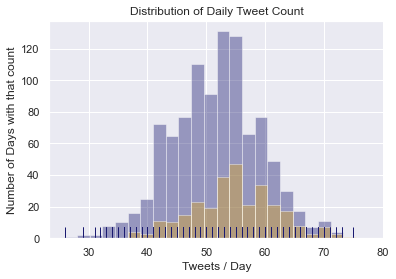

In [4]:
sample_mean = tweet_counts.mean()
bins = np.linspace(0.5*sample_mean, 1.5*sample_mean, 25)
weekend_msk = tweet_counts.index.map(lambda x: x.dayofweek in (5,6)).values
weekday_msk = tweet_counts.index.map(lambda x: x.dayofweek not in (5,6)).values
twoday_msk = tweet_counts.index.map(lambda x: x.dayofweek in (2,3)).values
ax = sns.distplot(
    tweet_counts, 
    bins=bins, 
    rug=True,
    kde=False,
    color='midnightblue',
)
ax = sns.distplot(
    tweet_counts[weekend_msk],
    bins=bins,
    rug=False,
    kde=False,
    color='goldenrod',
    ax=ax,
)
_ = ax.set_xlabel('Tweets / Day')
_ = ax.set_ylabel('Number of Days with that count')
_ = ax.set_title('Distribution of Daily Tweet Count')

It looks like the weekdays have a lower mean than the weekends, perhaps? How can we decide if that is a significant difference or not?

In [5]:
display(tweet_counts[weekend_msk].describe())
display(tweet_counts[np.logical_not(weekend_msk)].describe())

count    286.000000
mean      54.849650
std        7.166818
min       38.000000
25%       50.000000
50%       54.000000
75%       60.000000
max       75.000000
dtype: float64

count    714.000000
mean      50.488796
std        7.252065
min       26.000000
25%       46.000000
50%       51.000000
75%       55.000000
max       73.000000
dtype: float64

The means do differ but by less than either distribution's standard deviation. The two histograms are completely overlapping.

## Statistical Tests

A statistical test consists of a test statistic and its distribution. The general procedure is to calculate the statistic and then see what fraction of the distribution has more extreme values of the statistic.

Let's use our tweet data as an example and run the two-sample t-test to determine whether the observed difference in means is significant.

In [6]:
stats.ttest_ind(tweet_counts[np.logical_not(weekend_msk)], tweet_counts[weekend_msk])

Ttest_indResult(statistic=-8.621765996954668, pvalue=2.555337344825485e-17)

In [7]:
sample_sizes = [5, 10, 25, 50, 100]
for sample_size in sample_sizes:
    print(f"{sample_size} points from each: ", stats.ttest_ind(
        tweet_counts[np.logical_not(weekend_msk)].sample(sample_size), 
        tweet_counts[weekend_msk].sample(sample_size)
    ))

5 points from each:  Ttest_indResult(statistic=-1.6073673796734944, pvalue=0.14664073512148978)
10 points from each:  Ttest_indResult(statistic=-1.6067956679784843, pvalue=0.125498901180735)
25 points from each:  Ttest_indResult(statistic=-2.3249025072574945, pvalue=0.024352971212103128)
50 points from each:  Ttest_indResult(statistic=-2.471285147067676, pvalue=0.01518816691728996)
100 points from each:  Ttest_indResult(statistic=-5.176349588253852, pvalue=5.535920482855567e-07)


For all but the smallest samples, we find that it is very unlikely (< 5% chance) that the two samples have the same mean.

[When to use which statistical test](https://towardsdatascience.com/statistical-tests-when-to-use-which-704557554740)

We can also look at the difference of means in a less formal way using random number generation.

## Hacker method

We have a set of data and we can generate new realizations of that data by randomly choosing elements with replacement. This is called bootstrapping.

In [8]:
def mean_bootstrap(data):
    return data.sample(frac=1.0, replace=True).mean()

In [17]:
n_bootstraps = 1000

n_weekday = weekday_msk.sum()
weekday_means = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    weekday_means[i] = mean_bootstrap(tweet_counts[weekday_msk])
    
n_weekend = weekend_msk.sum()
weekend_means = np.zeros(n_bootstraps)
for i in range(n_bootstraps):
    weekend_means[i] = mean_bootstrap(tweet_counts[weekend_msk])

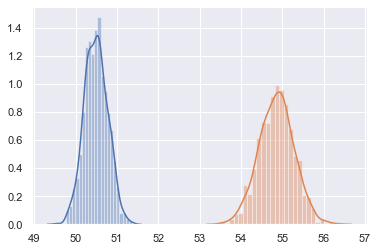

In [21]:
sns.distplot(weekday_means)
sns.distplot(weekend_means)

The distribution of bootstrap samples do not overlap at all. 

The t-test is parametric and depends on assumptions about the data you are comparing. 

There are also non-parametric tests which are useful for cases where the data may not meet those assumptions.

An example of a non-parametric test is the Kolmogorov–Smirnov test which uses the cumulative distribution of the data and either a reference distribution or another dataset.

In [23]:
stats.ks_2samp(weekend_means, weekday_means)

Ks_2sampResult(statistic=1.0, pvalue=0.0)

## Exercise: regenerate the data with a smaller difference of means and re-run both of the above tests

There is an argument to the `tweets_data` function called `wknd_offset`which is set to 0.1 by default, set this to a lower value and generate the data and bootstrap samples using new weekend/weekday masks as above. Then run both the t-test and the KS test on your new simulated data.